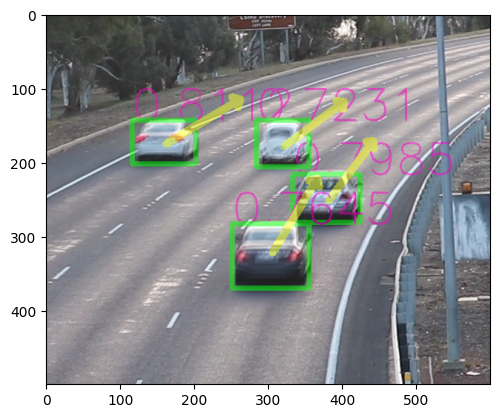

In [8]:
import pickle
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from mcf.data_types import Frame
from mcf.data_types import DetectionRegion
from mcf.common import get_center_of_mass

GREEN = (0,255,0)
RED = (0,0,255)
PURPLE = (200, 0, 256)
BLUE = (255,0,0)

with open("./data/current_frame_matching.pickle", "rb") as f:
    current_frame: Frame = pickle.load(f)

with open("./data/last_frame_matching.pickle", "rb") as f:
    last_frame: Frame = pickle.load(f)

def add_bounding_box(image: np.array, bounding_box: tuple[tuple[int,int],tuple[int,int]], color):
    top_left, bottom_right = bounding_box
    # add bounding box
    cv.rectangle(image, top_left, bottom_right, color, 1)

alpha = 0.5
blended_image = cv.addWeighted(last_frame.image, alpha, current_frame.image, 1 - alpha, 0)
plt.imshow(blended_image[300:800,1000:1600,::-1])

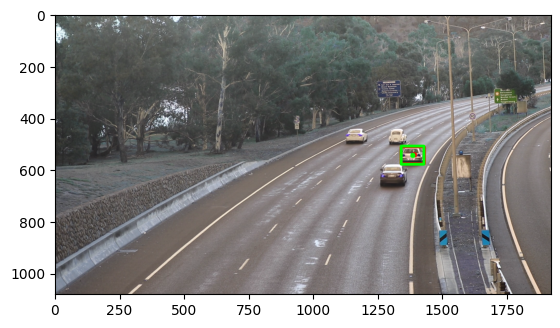

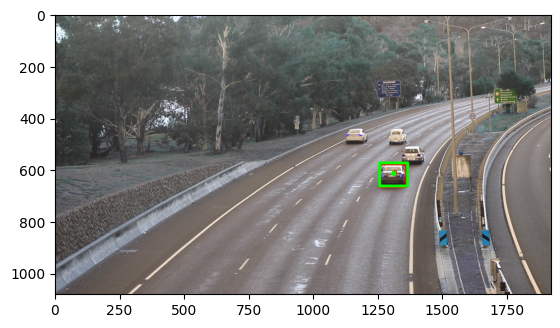

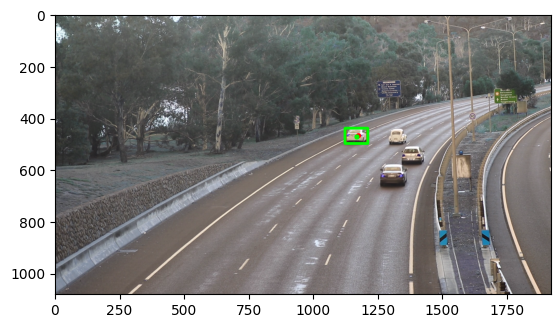

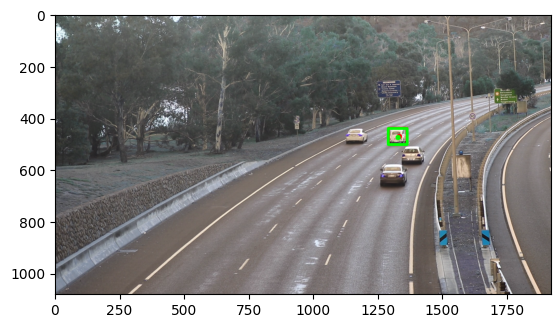

(((1284, 443), (1355, 506)), ((1120, 440), (1208, 499)))

In [18]:
import heapq

def euclidean_distance(loc1, loc2):
    loc1_y, loc1_x = loc1
    loc2_y, loc2_x = loc2
    dy = loc1_y - loc2_y
    dx = loc1_x - loc2_x
    distance = dy**2 + dx**2 
    return distance

def intersection_over_union(box1, box2):
    (x1_1, y1_1), (x2_1, y2_1) = box1
    (x1_2, y1_2), (x2_2, y2_2) = box2
    intersection_area = max(0, min(x2_1, x2_2) - max(x1_1, x1_2)) * max(0, min(y2_1, y2_2) - max(y1_1, y1_2))
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - intersection_area
    iou = intersection_area / union_area
    return iou

def matching_criteria(detection_region_last, detection_region_current):
    predicted_com = detection_region_last.next_center_of_mass
    predicted_bbox = detection_region_last.next_bounding_box
    predicted_com = predicted_com[1] + predicted_bbox[0][0], predicted_com[0] + predicted_bbox[0][1]

    measured_com = detection_region_current.center_of_mass
    measured_bbox = detection_region_current.bounding_box
    measured_com = measured_com[1] + measured_bbox[0][0], measured_com[0] + measured_bbox[0][1]

    dist = euclidean_distance(predicted_com, measured_com)
    iou = intersection_over_union(predicted_bbox, measured_bbox)
    return dist*2*(1-iou)

def get_all_match_pairs(last_detection_regions: list[DetectionRegion], current_detection_regions: list[DetectionRegion]):
    match_permutations = [] # min heap
    for pidx, last_detection_region in enumerate(last_detection_regions):
        for midx, current_detection_region in enumerate(current_detection_regions):
            criterion = matching_criteria(last_detection_region, current_detection_region)
            heapq.heappush(match_permutations, (criterion, pidx, midx))
    return match_permutations

def assign_optimal_matches(match_permutations, last_detection_regions: list[DetectionRegion], current_detection_regions: list[DetectionRegion]):
    regions_to_match = {x for x in range(len(current_frame.detection_regions))}

    while (len(regions_to_match) > 0):
        next_pair = heapq.heappop(match_permutations)

        pidx = next_pair[1]
        midx = next_pair[2]
        last_detection_region = last_frame.detection_regions[pidx]
        current_detection_region = current_frame.detection_regions[midx]

        current_detection_region.last_center_of_mass = last_detection_region.next_center_of_mass
        current_detection_region.last_bounding_box = last_detection_region.next_bounding_box
        current_detection_region.velocities.append(last_detection_region.velocities)

        regions_to_match.remove(midx)

    
def region_matching(last_detection_regions: list[DetectionRegion], current_detection_regions: list[DetectionRegion]):
    match_permutations = get_all_match_pairs(last_detection_regions, current_detection_regions)
    assign_optimal_matches(match_permutations, last_detection_regions, current_detection_regions)
    

for detection_region in current_frame.detection_regions:    
    bbox1 = detection_region.last_bounding_box
    bbox2 = detection_region.bounding_box

    com1 = detection_region.last_center_of_mass
    com1 = com1[1] + bbox1[0][0], com1[0] + bbox1[0][1]

    com2 = detection_region.center_of_mass
    com2 = com2[1] + bbox2[0][0], com2[0] + bbox2[0][1]

    image = current_frame.image.copy()

    cv.circle(image, com1, 10, (255, 0, 0), -1)
    cv.circle(image, com2, 10, (0, 255, 0), -1)
    cv.rectangle(image, (bbox1[0][0], bbox1[0][1]), (bbox1[1][0], bbox1[1][1]), (255, 0, 0), 10)
    cv.rectangle(image, (bbox2[0][0], bbox2[0][1]), (bbox2[1][0], bbox2[1][1]), (0, 255, 0), 10)
    plt.imshow(image)
    plt.show()

# print(next_pair)

last_frame.detection_regions[3].bounding_box, current_frame.detection_regions[2].bounding_box